In [3]:
import pandas as pd
import numpy as np
import healpy as hp
import astropy.units as u
from astropy.coordinates import SkyCoord, CartesianRepresentation, Galactic,  cartesian_to_spherical
import matplotlib.pyplot as plt
from healpy import projview

import pyccl as ccl
from scipy import integrate
import pyccl as ccl
from scipy.optimize import curve_fit
from scipy.integrate import quad

In [4]:
# vamos definir os parâmetros de pixelização (nside=2 produz 192 calotas esféricas)

nside = 4
npix = hp.nside2npix(nside)

In [5]:
# Vamos obter as coordenadas dos centros dos pixels para nside=4

lon, lat = hp.pix2ang(nside, range(npix), lonlat=True)

galactic_coords = SkyCoord(l=lon, b=lat, frame='galactic', unit='deg')
equatorial_coords = galactic_coords.icrs #transform_to('icrs')

ra_pixel = equatorial_coords.ra.deg
dec_pixel = equatorial_coords.dec.deg

In [6]:
data = pd.read_csv('/home/sofia/Documentos/Pantheon/Pantheon+SH0ES.csv', sep=' ')
data

,CID,IDSURVEY,zHD,zHDERR,zCMB,zCMBERR,zHEL,zHELERR,m_b_corr,m_b_corr_err_DIAG,...,PKMJDERR,NDOF,FITCHI2,FITPROB,m_b_corr_err_RAW,m_b_corr_err_VPEC,biasCor_m_b,biasCorErr_m_b,biasCor_m_b_COVSCALE,biasCor_m_b_COVADD
0,2011fe,51,0.00122,0.00084,0.00122,0.00002,0.00082,0.00002,9.74571,1.516210,...,0.1071,36,26.88590,0.864470,0.0991,1.4960,0.0381,0.005,1.000,0.003
1,2011fe,56,0.00122,0.00084,0.00122,0.00002,0.00082,0.00002,9.80286,1.517230,...,0.0579,101,88.30640,0.812220,0.0971,1.4960,-0.0252,0.003,1.000,0.004
2,2012cg,51,0.00256,0.00084,0.00256,0.00002,0.00144,0.00002,11.47030,0.781906,...,0.0278,165,233.50000,0.000358,0.0399,0.7134,0.0545,0.019,1.000,0.036
3,2012cg,56,0.00256,0.00084,0.00256,0.00002,0.00144,0.00002,11.49190,0.798612,...,0.0667,55,100.12200,0.000193,0.0931,0.7134,0.0622,0.028,1.000,0.040
4,1994DRichmond,50,0.00299,0.00084,0.00299,0.00004,0.00187,0.00004,11.52270,0.880798,...,0.0522,146,109.83900,0.988740,0.0567,0.6110,0.0650,0.009,1.000,0.006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1696,rutledge,106,1.61505,0.00545,1.61499,0.00500,1.61399,0.00500,25.90650,0.331927,...,1.7256,8,2.92493,0.938980,0.2230,0.0106,-0.0203,0.005,1.000,0.002
1697,geta,106,1.69706,0.04006,1.69702,0.04000,1.70000,0.04000,26.03330,0.379521,...,1.8973,12,9.15387,0.689730,0.3209,0.0748,0.2680,0.005,0.633,0.000
1698,stone,106,1.80119,0.02014,1.80111,0.02000,1.80000,0.02000,26.23350,0.280685,...,1.1631,11,11.69320,0.387140,0.2370,0.0358,-0.0968,0.004,0.641,0.000
1699,wilson,106,1.91165,0.00263,1.91160,0.00100,1.91401,0.00100,26.17030,0.357624,...,1.4902,9,5.54378,0.784570,0.3168,0.0044,-0.3835,0.013,0.604,0.000


In [7]:
#Acrescentando uma tabela de índices à tabela

index = []
for i in range(1701):
    index.append(i)
    
data['index'] = index

In [8]:
data

,CID,IDSURVEY,zHD,zHDERR,zCMB,zCMBERR,zHEL,zHELERR,m_b_corr,m_b_corr_err_DIAG,...,NDOF,FITCHI2,FITPROB,m_b_corr_err_RAW,m_b_corr_err_VPEC,biasCor_m_b,biasCorErr_m_b,biasCor_m_b_COVSCALE,biasCor_m_b_COVADD,index
0,2011fe,51,0.00122,0.00084,0.00122,0.00002,0.00082,0.00002,9.74571,1.516210,...,36,26.88590,0.864470,0.0991,1.4960,0.0381,0.005,1.000,0.003,0
1,2011fe,56,0.00122,0.00084,0.00122,0.00002,0.00082,0.00002,9.80286,1.517230,...,101,88.30640,0.812220,0.0971,1.4960,-0.0252,0.003,1.000,0.004,1
2,2012cg,51,0.00256,0.00084,0.00256,0.00002,0.00144,0.00002,11.47030,0.781906,...,165,233.50000,0.000358,0.0399,0.7134,0.0545,0.019,1.000,0.036,2
3,2012cg,56,0.00256,0.00084,0.00256,0.00002,0.00144,0.00002,11.49190,0.798612,...,55,100.12200,0.000193,0.0931,0.7134,0.0622,0.028,1.000,0.040,3
4,1994DRichmond,50,0.00299,0.00084,0.00299,0.00004,0.00187,0.00004,11.52270,0.880798,...,146,109.83900,0.988740,0.0567,0.6110,0.0650,0.009,1.000,0.006,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1696,rutledge,106,1.61505,0.00545,1.61499,0.00500,1.61399,0.00500,25.90650,0.331927,...,8,2.92493,0.938980,0.2230,0.0106,-0.0203,0.005,1.000,0.002,1696
1697,geta,106,1.69706,0.04006,1.69702,0.04000,1.70000,0.04000,26.03330,0.379521,...,12,9.15387,0.689730,0.3209,0.0748,0.2680,0.005,0.633,0.000,1697
1698,stone,106,1.80119,0.02014,1.80111,0.02000,1.80000,0.02000,26.23350,0.280685,...,11,11.69320,0.387140,0.2370,0.0358,-0.0968,0.004,0.641,0.000,1698
1699,wilson,106,1.91165,0.00263,1.91160,0.00100,1.91401,0.00100,26.17030,0.357624,...,9,5.54378,0.784570,0.3168,0.0044,-0.3835,0.013,0.604,0.000,1699


1) Definindo os conjuntos limitados por zmin e zmax:


In [9]:
#Definindo o conjunto com zmin = 0.01 e zmax = 0.15

data1 = data[(data['zCMB'] >= 0.01)&(data['zCMB'] <= 0.15)]
print(len(data1))

ra_data1 = data1['RA']* np.pi / 180
dec_data1 = data1['DEC']* np.pi / 180

713


In [10]:
#Definindo o conjunto com zmin = 0.01 e zmax = 0.2

data2 = data[(data['zCMB'] >= 0.01)&(data['zCMB'] <= 0.2)]
print(len(data2))

ra_data2 = data2['RA']* np.pi / 180
dec_data2 = data2['DEC']* np.pi / 180

835


In [11]:
#Definindo o conjunto com zmin = 0.015 e zmax = 0.15

data3 = data[(data['zCMB'] >= 0.015)&(data['zCMB'] <= 0.15)]
print(len(data3))

ra_data3 = data3['RA']* np.pi / 180
dec_data3 = data3['DEC']* np.pi / 180

649


In [12]:
#Definindo o conjunto com zmin = 0.015 e zmax = 0.2

data4 = data[(data['zCMB'] >= 0.015)&(data['zCMB'] <= 0.2)]
print(len(data4))

ra_data4 = data['RA']* np.pi / 180
dec_data4 = data['DEC']* np.pi / 180

771


2) Assumindo os parâmetros cosmológicos dos resultados do Planck 2018 (Veja as colunas TT, TE,EE+lowE da Tabela 2, arXiv:1807.06209), utilize pyccl e o matplotlib para realizar o melhor ajuste dos parâmetros cosmológicos (utilizando a matriz de covariância da colaboração) para cada uma das amostras mencionadas no item (1).

2.1) Deixe $H_0$ e $\Omega_m$ como parâmetros livres.

In [13]:
# Raio do círculo em graus
raio = 90

n = 191
cont = 0

while cont <= n:
    
    # Coordenadas do centro do círculo/pixel em radianos
    ra_centro1 = ra_pixel[cont]* np.pi / 180
    dec_centro1 = dec_pixel[cont]* np.pi / 180
    
    # Usando a fórmula de Haversine
    delta_ra1 = ra_data1 - ra_centro1
    delta_dec1 = dec_data1 - dec_centro1
    
    a = np.sin(delta_dec1 / 2)**2 + np.cos(dec_centro1) * np.cos(dec_data1) * np.sin(delta_ra1 / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    distancia = np.degrees(c)
    objetos1 = data1[distancia <= raio]
    
    local = f'/home/sofia/Documentos/Pantheon/Atividade 4/Hemisferios 1/{cont:03d}.csv'
    objetos1.to_csv(local, index=False)
 
    cont += 1

In [14]:
# Raio do círculo em graus
raio = 90

n = 191
cont = 0

while cont <= n:
    
    # Coordenadas do centro do círculo/pixel em radianos
    ra_centro2 = ra_pixel[cont]* np.pi / 180
    dec_centro2 = dec_pixel[cont]* np.pi / 180
    
    # Usando a fórmula de Haversine
    delta_ra2 = ra_data2 - ra_centro2
    delta_dec2 = dec_data2 - dec_centro2
    
    a = np.sin(delta_dec2 / 2)**2 + np.cos(dec_centro2) * np.cos(dec_data2) * np.sin(delta_ra2 / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    distancia = np.degrees(c)
    objetos2 = data2[distancia <= raio]
    
    local = f'/home/sofia/Documentos/Pantheon/Atividade 4/Hemisferios 2/{cont:03d}.csv'
    objetos2.to_csv(local, index=False)
 
    cont += 1

In [15]:
# Raio do círculo em graus
raio = 90

n = 191
cont = 0

while cont <= n:
    
    # Coordenadas do centro do círculo/pixel em radianos
    ra_centro3 = ra_pixel[cont]* np.pi / 180
    dec_centro3 = dec_pixel[cont]* np.pi / 180
    
    # Usando a fórmula de Haversine
    delta_ra3 = ra_data3 - ra_centro3
    delta_dec3 = dec_data3 - dec_centro3
    
    a = np.sin(delta_dec3 / 2)**2 + np.cos(dec_centro3) * np.cos(dec_data3) * np.sin(delta_ra3 / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    distancia = np.degrees(c)
    objetos3 = data3[distancia <= raio]
    
    local = f'/home/sofia/Documentos/Pantheon/Atividade 4/Hemisferios 3/{cont:03d}.csv'
    objetos3.to_csv(local, index=False)
 
    cont += 1

In [16]:
# Raio do círculo em graus
raio = 90

n = 191
cont = 0

while cont <= n:
    
    # Coordenadas do centro do círculo/pixel em radianos
    ra_centro4 = ra_pixel[cont]* np.pi / 180
    dec_centro4 = dec_pixel[cont]* np.pi / 180
    
    # Usando a fórmula de Haversine
    delta_ra4 = ra_data4 - ra_centro4
    delta_dec4 = dec_data4 - dec_centro4
    
    a = np.sin(delta_dec4/ 2)**2 + np.cos(dec_centro4) * np.cos(dec_data4) * np.sin(delta_ra4 / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    distancia = np.degrees(c)
    objetos4 = data1[distancia <= raio]
    
    local = f'/home/sofia/Documentos/Pantheon/Atividade 4/Hemisferios 4/{cont:03d}.csv'
    objetos4.to_csv(local, index=False)
 
    cont += 1

/tmp/ipykernel_15852/3306823791.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  objetos4 = data1[distancia <= raio]
/tmp/ipykernel_15852/3306823791.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  objetos4 = data1[distancia <= raio]
/tmp/ipykernel_15852/3306823791.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  objetos4 = data1[distancia <= raio]
/tmp/ipykernel_15852/3306823791.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  objetos4 = data1[distancia <= raio]
/tmp/ipykernel_15852/3306823791.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  objetos4 = data1[distancia <= raio]
/tmp/ipykernel_15852/3306823791.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  objetos4 = data1[distancia <= raio]
/tmp/ipykernel_15852/3306823791.py:21: UserWarning: Boolean Series key will be rei

In [17]:
index1 = []
zCMB1 = []
MU_SHOES1 = []

for i in range(192):
    di = f'/home/sofia/Documentos/Pantheon/Atividade 4/Hemisferios 1/{i:03d}.csv'

    hemis = pd.read_csv(di)
    index1.append(hemis['index'].values)
    zCMB1.append(hemis['zCMB'].values)
    MU_SHOES1.append(hemis['MU_SH0ES'].values)

In [18]:
index2 = []
zCMB2 = []
MU_SHOES2 = []

for i in range(192):
    di = f'/home/sofia/Documentos/Pantheon/Atividade 4/Hemisferios 2/{i:03d}.csv'

    hemis = pd.read_csv(di)
    index2.append(hemis['index'].values)
    zCMB2.append(hemis['zCMB'].values)
    MU_SHOES2.append(hemis['MU_SH0ES'].values)

In [19]:
index3 = []
zCMB3 = []
MU_SHOES3 = []

for i in range(192):
    di = f'/home/sofia/Documentos/Pantheon/Atividade 4/Hemisferios 3/{i:03d}.csv'

    hemis = pd.read_csv(di)
    index3.append(hemis['index'].values)
    zCMB3.append(hemis['zCMB'].values)
    MU_SHOES3.append(hemis['MU_SH0ES'].values)

In [20]:
index4 = []
zCMB4 = []
MU_SHOES4 = []

for i in range(192):
    di = f'/home/sofia/Documentos/Pantheon/Atividade 4/Hemisferios 4/{i:03d}.csv'

    hemis = pd.read_csv(di)
    index4.append(hemis['index'].values)
    zCMB4.append(hemis['zCMB'].values)
    MU_SHOES4.append(hemis['MU_SH0ES'].values)

In [21]:
cove = np.genfromtxt('/home/sofia/Documentos/Pantheon/Pantheon+SH0ES_STAT+SYS.cov', skip_header=1)
cov = np.reshape(cove, (1701, 1701))

In [22]:
def mu_fit_integral(z, H0, Om):
    c = 299793.458
    Om_lamb = 1 - Om

    def integrando(z):
        return 1 / np.sqrt(Om * (1 + z)**3 + Om_lamb)

    mu_values = []

    for z_val in z:
        I, _ = integrate.quad(integrando, 0, z_val) 
        dL = (c / H0) * (1 + z_val) * I
        mu = 5 * np.log10(dL) + 25
        mu_values.append(mu)

    return np.array(mu_values)


def mu_fit_ccl(z, Om0, h0):
    
    cosmo = ccl.Cosmology(
        Omega_c= Om0-0.0494, Omega_b=0.0494, 
        h=h0, sigma8=0.8120, n_s=0.9649)
    
    a = 1/(1+z)
    
    return ccl.background.distance_modulus(cosmo, a)

In [23]:
H0_i1 = []
Om_i1 = []

H0_c1 = []
Om_c1 = []

for i in range(192):
    
    I_h = np.int64(index1[i])
    E_h = cov[np.ix_(I_h, I_h)]
    
    p0_i = [70, 0.3]
    curve_i, cove_i = curve_fit(mu_fit_integral, zCMB1[i], MU_SHOES1[i], 
                                p0=p0_i, sigma=E_h, method='trf')
    print(curve_i)
    H0_i1.append(curve_i[0])
    Om_i1.append(curve_i[1])

    curve_c, cove_c = curve_fit(mu_fit_ccl, zCMB1[i], MU_SHOES1[i], bounds=([0, 0],[1, 1]), sigma=E_h, 
                            method='trf')
        
    print(curve_c)
    H0_c1.append(100 * np.array(curve_c[1]))
    Om_c1.append(curve_c[0])

[73.48571671  0.21695487]
[0.21685214 0.73485466]
[73.46832964  0.2127233 ]
[0.21261993 0.73468081]
[73.4982413   0.21138334]
[0.21127781 0.73497997]
[73.50117922  0.21073953]
[0.2106377  0.73500927]
[73.51361506  0.2251694 ]
[0.22506971 0.73513357]
[73.14700438  0.30739491]
[0.30729022 0.73146757]
[73.00053559  0.32820946]
[0.32810838 0.7300028 ]
[73.31496675  0.24119152]
[0.24109311 0.73314706]
[73.35913919  0.24234731]
[0.24224409 0.73358889]
[73.50789088  0.20741551]
[0.2073195  0.73507625]
[73.47767872  0.21853378]
[0.21842933 0.73477432]
[73.54283638  0.20698718]
[0.20689281 0.73542566]
[73.27521797  0.31342194]
[0.31332145 0.7327496 ]
[73.13396943  0.30127821]
[0.30117222 0.73133724]
[72.74172712  0.36486108]
[0.36476084 0.72741466]
[72.48597232  0.43978514]
[0.43968144 0.72485721]
[72.86166173  0.33993051]
[0.33983662 0.7286139 ]
[72.859538   0.3319688]
[0.33186909 0.72859279]
[73.20958721  0.25154031]
[0.25143773 0.73209336]
[73.45079401  0.19078796]
[0.19068984 0.73450533]
[7

In [24]:
H0_i2 = []
Om_i2 = []

H0_c2 = []
Om_c2 = []

for i in range(192):
    
    I_h = np.int64(index2[i])
    E_h = cov[np.ix_(I_h, I_h)]
    
    p0_i = [70, 0.3]
    curve_i2, cove_i2 = curve_fit(mu_fit_integral, zCMB2[i], MU_SHOES2[i], 
                                p0=p0_i, sigma=E_h, method='trf')
    print(curve_i2)
    H0_i2.append(curve_i2[0])
    Om_i2.append(curve_i2[1])

    curve_c2, cove_c2 = curve_fit(mu_fit_ccl, zCMB2[i], MU_SHOES2[i], bounds=([0, 0],[1, 1]), sigma=E_h, 
                            method='trf')
        
    print(curve_c2)
    H0_c2.append(100 * np.array(curve_c2[1]))
    Om_c2.append(curve_c2[0])

[73.41390378  0.24811125]
[0.24800367 0.73413662]
[73.38186574  0.25084213]
[0.25073548 0.73381621]
[73.41378382  0.24847126]
[0.24836416 0.73413541]
[73.4150538   0.24859305]
[0.2484846  0.73414815]
[73.44854882  0.25272092]
[0.25261422 0.73448305]
[73.09663497  0.32990426]
[0.3297946  0.73096397]
[73.03712505  0.30588744]
[0.30577893 0.73036884]
[73.25301525  0.2680558 ]
[0.26794597 0.73252779]
[73.31227039  0.26147444]
[0.26136649 0.73312029]
[73.41986181  0.24580511]
[0.24569715 0.73419621]
[73.40261166  0.25094901]
[0.25083999 0.73402374]
[73.46278118  0.24190693]
[0.24180039 0.73462537]
[73.09138289  0.43331726]
[0.43320918 0.73091139]
[72.94336158  0.41509063]
[0.41497998 0.72943125]
[72.58570154  0.46463221]
[0.46452185 0.72585462]
[72.61752072  0.36847097]
[0.36836168 0.7261728 ]
[72.90230716  0.31590702]
[0.31579887 0.72902065]
[72.897046    0.31037226]
[0.31026383 0.72896804]
[73.16863947  0.26768547]
[0.26757451 0.73168406]
[73.34213213  0.2389589 ]
[0.23885077 0.73341892]


In [25]:
H0_i3 = []
Om_i3 = []

H0_c3 = []
Om_c3 = []

for i in range(192):
    
    I_h = np.int64(index3[i])
    E_h = cov[np.ix_(I_h, I_h)]
    
    p0_i = [70, 0.3]
    curve_i3, cove_i3 = curve_fit(mu_fit_integral, zCMB3[i], MU_SHOES3[i], 
                                p0=p0_i, sigma=E_h, method='trf')
    print(curve_i3)
    H0_i3.append(curve_i3[0])
    Om_i3.append(curve_i3[1])

    curve_c3, cove_c3 = curve_fit(mu_fit_ccl, zCMB3[i], MU_SHOES3[i], bounds=([0, 0],[1, 1]), sigma=E_h, 
                            method='trf')
        
    print(curve_c3)
    H0_c3.append(100 * np.array(curve_c3[1]))
    Om_c3.append(curve_c3[0])

[73.45805288  0.21510607]
[0.21499601 0.73457819]
[73.43437459  0.21242875]
[0.21231855 0.73434141]
[73.46981391  0.20972447]
[0.20961927 0.73469569]
[73.47398695  0.20877354]
[0.20867503 0.73473726]
[73.51688791  0.21628491]
[0.2161833  0.73516634]
[73.15003534  0.3007722 ]
[0.30066721 0.73149788]
[72.96192338  0.33211142]
[0.33201042 0.72961667]
[73.26790426  0.24485762]
[0.24475155 0.73267661]
[73.31136278  0.2449871 ]
[0.24487776 0.73311127]
[73.43407313  0.21791332]
[0.21780358 0.73433839]
[73.44540916  0.21811133]
[0.21800062 0.73445177]
[73.49983967  0.20888945]
[0.20878744 0.73499587]
[73.36451728  0.28489473]
[0.28478854 0.73364273]
[73.20320345  0.2818351 ]
[0.28172814 0.73202961]
[72.7102721   0.36687126]
[0.36676397 0.72710028]
[72.43947235  0.44720796]
[0.44710018 0.7243923 ]
[72.80682722  0.34957708]
[0.34947323 0.72806577]
[72.82150411  0.34083349]
[0.34072693 0.7282126 ]
[73.17569755  0.25874611]
[0.25863774 0.73175459]
[73.40950773  0.19905498]
[0.19894937 0.73409263]


In [26]:
H0_i4 = []
Om_i4 = []

H0_c4 = []
Om_c4 = []

for i in range(192):
    
    I_h = np.int64(index4[i])
    E_h = cov[np.ix_(I_h, I_h)]
    
    p0_i = [70, 0.3]
    curve_i4, cove_i4 = curve_fit(mu_fit_integral, zCMB4[i], MU_SHOES4[i], 
                                p0=p0_i, sigma=E_h, method='trf')
    print(curve_i4)
    H0_i4.append(curve_i4[0])
    Om_i4.append(curve_i4[1])

    curve_c4, cove_c4 = curve_fit(mu_fit_ccl, zCMB4[i], MU_SHOES4[i], bounds=([0, 0],[1, 1]), sigma=E_h, 
                            method='trf')
        
    print(curve_c4)
    H0_c4.append(100 * np.array(curve_c4[1]))
    Om_c4.append(curve_c4[0])

[73.48571671  0.21695487]
[0.21685214 0.73485466]
[73.46832964  0.2127233 ]
[0.21261993 0.73468081]
[73.4982413   0.21138334]
[0.21127781 0.73497997]
[73.50117922  0.21073953]
[0.2106377  0.73500927]
[73.51361506  0.2251694 ]
[0.22506971 0.73513357]
[73.14700438  0.30739491]
[0.30729022 0.73146757]
[73.00053559  0.32820946]
[0.32810838 0.7300028 ]
[73.31496675  0.24119152]
[0.24109311 0.73314706]
[73.35913919  0.24234731]
[0.24224409 0.73358889]
[73.50789088  0.20741551]
[0.2073195  0.73507625]
[73.47767872  0.21853378]
[0.21842933 0.73477432]
[73.54283638  0.20698718]
[0.20689281 0.73542566]
[73.27521797  0.31342194]
[0.31332145 0.7327496 ]
[73.13396943  0.30127821]
[0.30117222 0.73133724]
[72.74172712  0.36486108]
[0.36476084 0.72741466]
[72.48597232  0.43978514]
[0.43968144 0.72485721]
[72.86166173  0.33993051]
[0.33983662 0.7286139 ]
[72.859538   0.3319688]
[0.33186909 0.72859279]
[73.20958721  0.25154031]
[0.25143773 0.73209336]
[73.45079401  0.19078796]
[0.19068984 0.73450533]
[7

In [28]:
#Vamos gerar os mapas

H0_pix1 = H0_i1
Om_pix1 = Om_i1

nside = 4  
npix = hp.nside2npix(nside) 

#criar um mapa vazio e atribuir os valores de números a cada pixel dele
H0_map1 = np.zeros(npix)
H0_map1[:len(H0_pix1)] = H0_pix1

Om_map1 = np.zeros(npix)
Om_map1[:len(Om_pix1)] = Om_pix1

hp.write_map('/home/sofia/Documentos/Pantheon/Atividade 4/H0_map_i_1.fits', H0_map1, overwrite=True)
hp.write_map('/home/sofia/Documentos/Pantheon/Atividade 4/Om_map_i_1.fits', Om_map1, overwrite=True)


H0_map_c1 = np.zeros(npix)
H0_map_c1[:len(H0_c1)] = H0_c1

Om_map_c1 = np.zeros(npix)
Om_map_c1[:len(Om_c1)] = Om_c1

hp.write_map('/home/sofia/Documentos/Pantheon/Atividade 4/H0_map_ccl_1.fits', H0_map_c1, overwrite=True)
hp.write_map('/home/sofia/Documentos/Pantheon/Atividade 4/Om_map_ccl_1.fits', Om_map_c1, overwrite=True)

setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


In [29]:
#Vamos gerar os mapas

H0_pix2 = H0_i2
Om_pix2 = Om_i2

nside = 4  
npix = hp.nside2npix(nside) 

#criar um mapa vazio e atribuir os valores de números a cada pixel dele
H0_map2 = np.zeros(npix)
H0_map2[:len(H0_pix2)] = H0_pix2

Om_map2 = np.zeros(npix)
Om_map2[:len(Om_pix2)] = Om_pix2

hp.write_map('/home/sofia/Documentos/Pantheon/Atividade 4/H0_map_i_2.fits', H0_map2, overwrite=True)
hp.write_map('/home/sofia/Documentos/Pantheon/Atividade 4/Om_map_i_2.fits', Om_map2, overwrite=True)


H0_map_c2 = np.zeros(npix)
H0_map_c2[:len(H0_c2)] = H0_c2

Om_map_c2 = np.zeros(npix)
Om_map_c2[:len(Om_c2)] = Om_c2

hp.write_map('/home/sofia/Documentos/Pantheon/Atividade 4/H0_map_ccl_2.fits', H0_map_c2, overwrite=True)
hp.write_map('/home/sofia/Documentos/Pantheon/Atividade 4/Om_map_ccl_2.fits', Om_map_c2, overwrite=True)

setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


In [30]:
#Vamos gerar os mapas

H0_pix3 = H0_i3
Om_pix3 = Om_i3

nside = 4  
npix = hp.nside2npix(nside) 

#criar um mapa vazio e atribuir os valores de números a cada pixel dele
H0_map3 = np.zeros(npix)
H0_map3[:len(H0_pix3)] = H0_pix3

Om_map3 = np.zeros(npix)
Om_map3[:len(Om_pix3)] = Om_pix3

hp.write_map('/home/sofia/Documentos/Pantheon/Atividade 4/H0_map_i_3.fits', H0_map3, overwrite=True)
hp.write_map('/home/sofia/Documentos/Pantheon/Atividade 4/Om_map_i_3.fits', Om_map3, overwrite=True)


H0_map_c3 = np.zeros(npix)
H0_map_c3[:len(H0_c3)] = H0_c3

Om_map_c3 = np.zeros(npix)
Om_map_c3[:len(Om_c3)] = Om_c3

hp.write_map('/home/sofia/Documentos/Pantheon/Atividade 4/H0_map_ccl_3.fits', H0_map_c3, overwrite=True)
hp.write_map('/home/sofia/Documentos/Pantheon/Atividade 4/Om_map_ccl_3.fits', Om_map_c3, overwrite=True)

setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


In [31]:
#Vamos gerar os mapas

H0_pix4 = H0_i4
Om_pix4 = Om_i4

nside = 4  
npix = hp.nside2npix(nside) 

#criar um mapa vazio e atribuir os valores de números a cada pixel dele
H0_map4 = np.zeros(npix)
H0_map4[:len(H0_pix4)] = H0_pix4

Om_map4 = np.zeros(npix)
Om_map4[:len(Om_pix4)] = Om_pix4

hp.write_map('/home/sofia/Documentos/Pantheon/Atividade 4/H0_map_i_4.fits', H0_map4, overwrite=True)
hp.write_map('/home/sofia/Documentos/Pantheon/Atividade 4/Om_map_i_4.fits', Om_map4, overwrite=True)


H0_map_c4 = np.zeros(npix)
H0_map_c4[:len(H0_c4)] = H0_c4

Om_map_c4 = np.zeros(npix)
Om_map_c4[:len(Om_c4)] = Om_c4

hp.write_map('/home/sofia/Documentos/Pantheon/Atividade 4/H0_map_ccl_4.fits', H0_map_c4, overwrite=True)
hp.write_map('/home/sofia/Documentos/Pantheon/Atividade 4/Om_map_ccl_4.fits', Om_map_c4, overwrite=True)

setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


In [32]:
fontsize = {
"xlabel": 15,           # Tamanho da fonte do rótulo do eixo x
"ylabel": 15,           # Tamanho da fonte do rótulo do eixo y
"title": 20,            # Tamanho da fonte do título
"xtick_label": 15,      # Tamanho da fonte dos rótulos do eixo x
"ytick_label": 15,      # Tamanho da fonte dos rótulos do eixo y
"cbar_label": 15,       # Tamanho da fonte da legenda da barra de cores
"cbar_tick_label": 15   # Tamanho da fonte dos rótulos da barra de cores
}

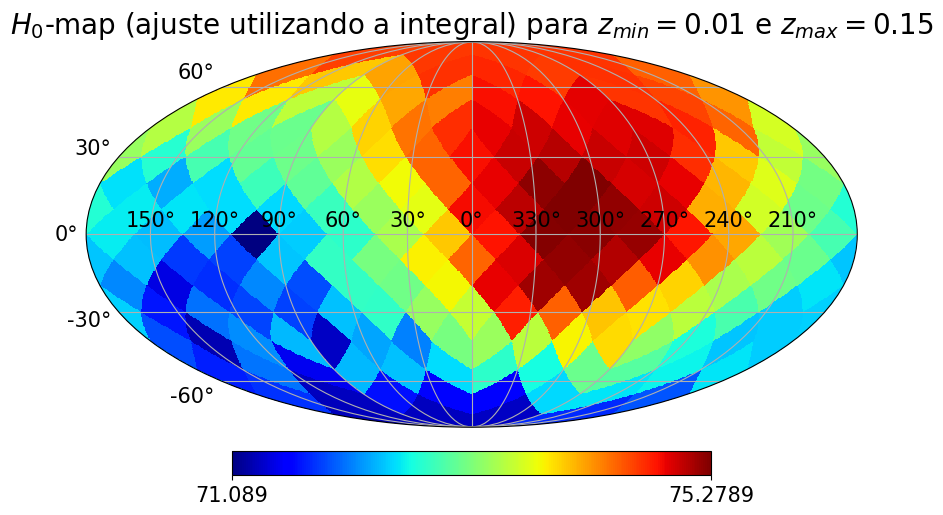

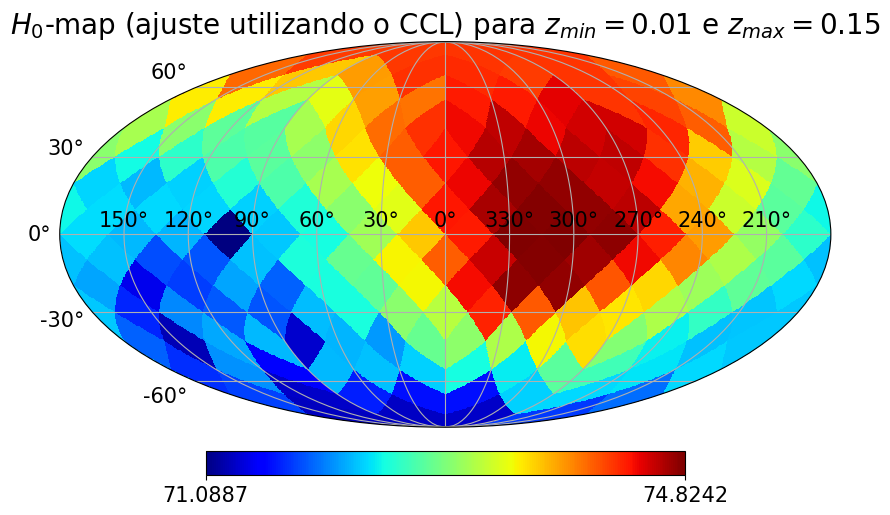

In [34]:
projview(H0_map1,
coord=["G"],
norm="hist",
cmap='jet',
title="$H_0$-map (ajuste utilizando a integral) para $z_{min}=0.01$ e $z_{max}=0.15$",
graticule=True,
graticule_labels=True,
longitude_grid_spacing=30,
projection_type="mollweide",
fontsize=fontsize)
plt.savefig('/home/sofia/Documentos/Pantheon/Atividade 4/H0_map_int_1.png', dpi=600, bbox_inches='tight')

projview(H0_map_c1,
coord=["G"],
norm="hist",
cmap='jet',
title="$H_0$-map (ajuste utilizando o CCL) para $z_{min}=0.01$ e $z_{max}=0.15$",
graticule=True,
graticule_labels=True,
longitude_grid_spacing=30,
projection_type="mollweide",
fontsize=fontsize)
plt.savefig('/home/sofia/Documentos/Pantheon/Atividade 4/H0_map_ccl_1.png', dpi=600, bbox_inches='tight')

plt.show()

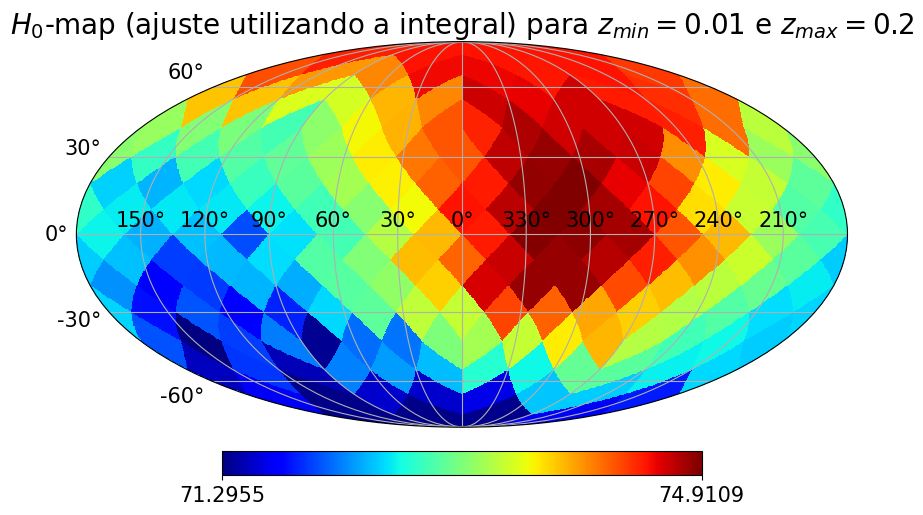

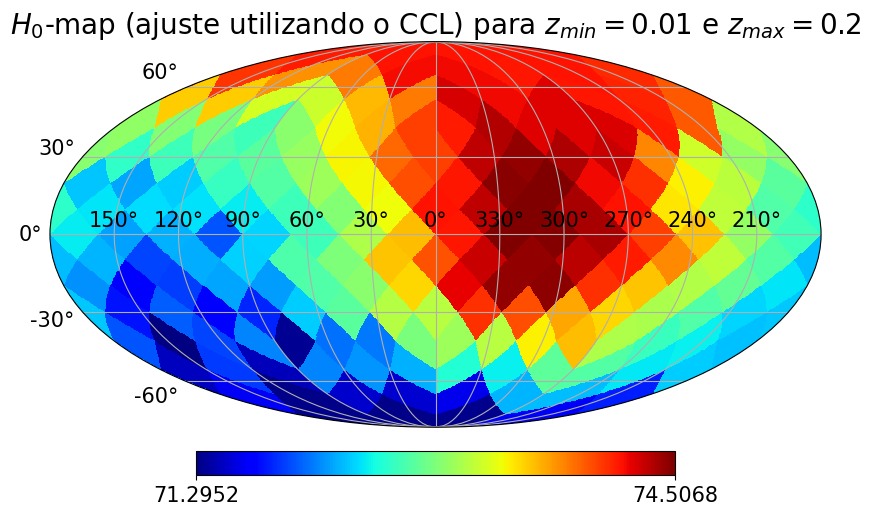

In [35]:
projview(H0_map2,
coord=["G"],
norm="hist",
cmap='jet',
title="$H_0$-map (ajuste utilizando a integral) para $z_{min}=0.01$ e $z_{max}=0.2$",
graticule=True,
graticule_labels=True,
longitude_grid_spacing=30,
projection_type="mollweide",
fontsize=fontsize)
plt.savefig('/home/sofia/Documentos/Pantheon/Atividade 4/H0_map_int_2.png', dpi=600, bbox_inches='tight')

projview(H0_map_c2,
coord=["G"],
norm="hist",
cmap='jet',
title="$H_0$-map (ajuste utilizando o CCL) para $z_{min}=0.01$ e $z_{max}=0.2$",
graticule=True,
graticule_labels=True,
longitude_grid_spacing=30,
projection_type="mollweide",
fontsize=fontsize)
plt.savefig('/home/sofia/Documentos/Pantheon/Atividade 4/H0_map_ccl_2.png', dpi=600, bbox_inches='tight')

plt.show()

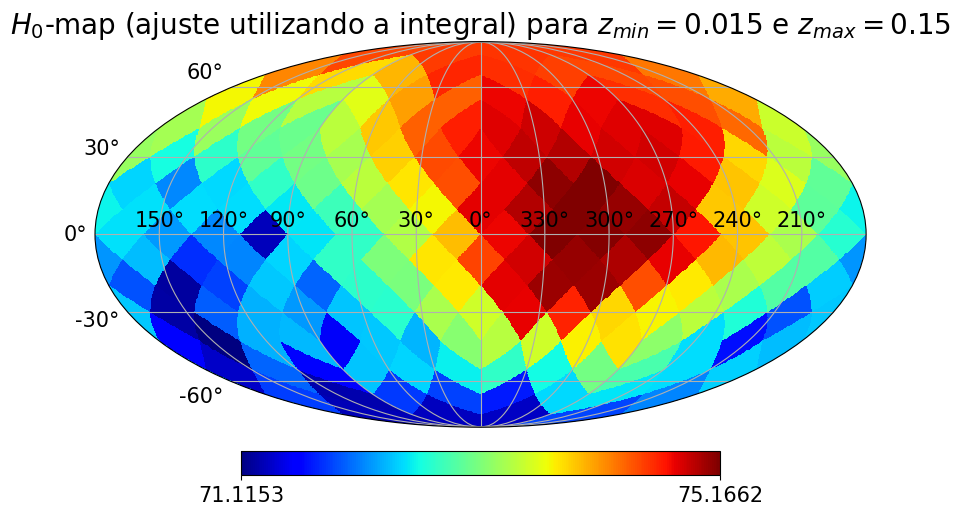

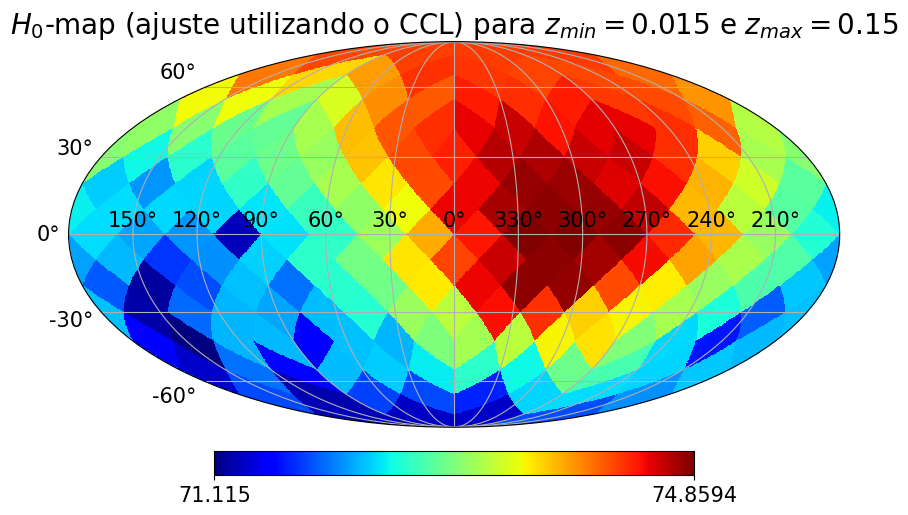

In [36]:
projview(H0_map3,
coord=["G"],
norm="hist",
cmap='jet',
title="$H_0$-map (ajuste utilizando a integral) para $z_{min}=0.015$ e $z_{max}=0.15$",
graticule=True,
graticule_labels=True,
longitude_grid_spacing=30,
projection_type="mollweide",
fontsize=fontsize)
plt.savefig('/home/sofia/Documentos/Pantheon/Atividade 4/H0_map_int_3.png', dpi=600, bbox_inches='tight')

projview(H0_map_c3,
coord=["G"],
norm="hist",
cmap='jet',
title="$H_0$-map (ajuste utilizando o CCL) para $z_{min}=0.015$ e $z_{max}=0.15$",
graticule=True,
graticule_labels=True,
longitude_grid_spacing=30,
projection_type="mollweide",
fontsize=fontsize)
plt.savefig('/home/sofia/Documentos/Pantheon/Atividade 4/H0_map_ccl_3.png', dpi=600, bbox_inches='tight')

plt.show()

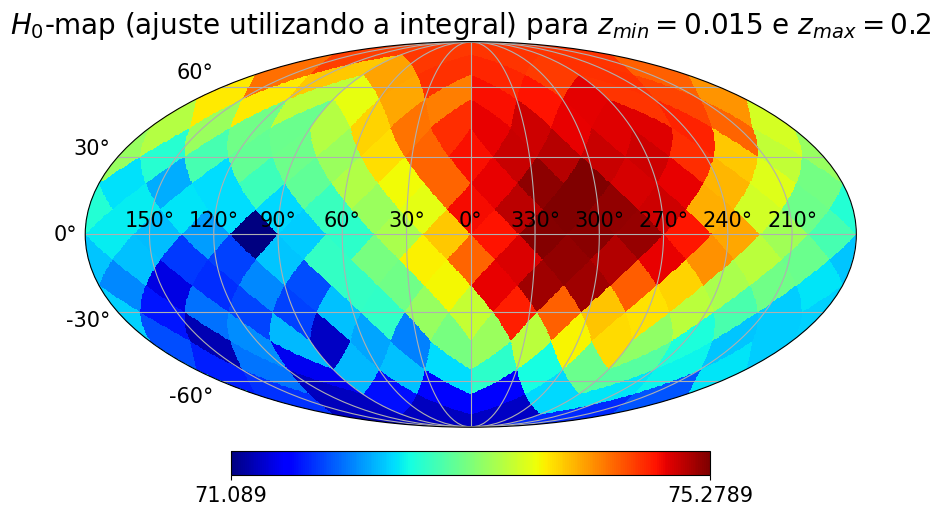

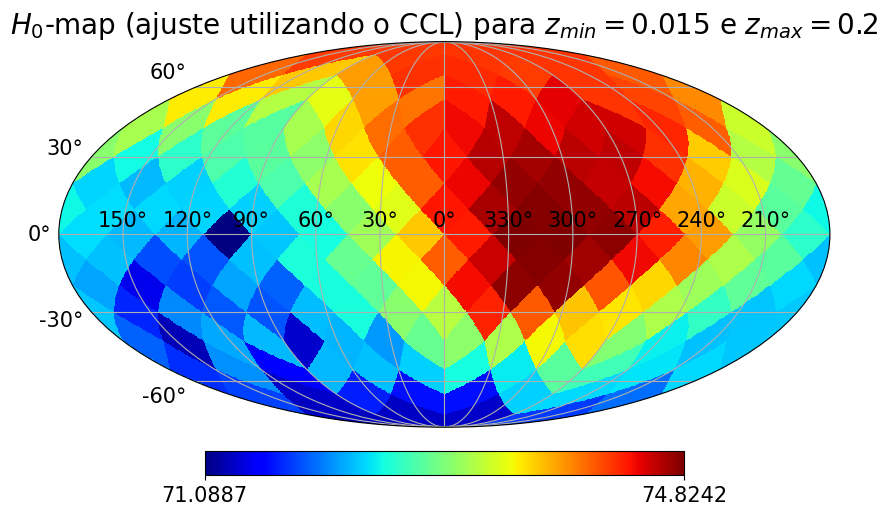

In [37]:
projview(H0_map4,
coord=["G"],
norm="hist",
cmap='jet',
title="$H_0$-map (ajuste utilizando a integral) para $z_{min}=0.015$ e $z_{max}=0.2$",
graticule=True,
graticule_labels=True,
longitude_grid_spacing=30,
projection_type="mollweide",
fontsize=fontsize)
plt.savefig('/home/sofia/Documentos/Pantheon/Atividade 4/H0_map_int_4.png', dpi=600, bbox_inches='tight')

projview(H0_map_c4,
coord=["G"],
norm="hist",
cmap='jet',
title="$H_0$-map (ajuste utilizando o CCL) para $z_{min}=0.015$ e $z_{max}=0.2$",
graticule=True,
graticule_labels=True,
longitude_grid_spacing=30,
projection_type="mollweide",
fontsize=fontsize)
plt.savefig('/home/sofia/Documentos/Pantheon/Atividade 4/H0_map_ccl_4.png', dpi=600, bbox_inches='tight')

plt.show()

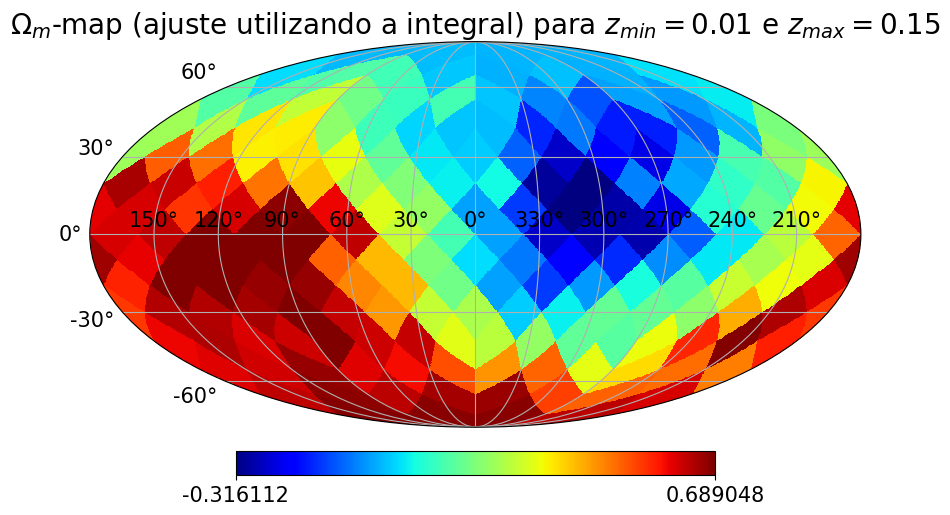

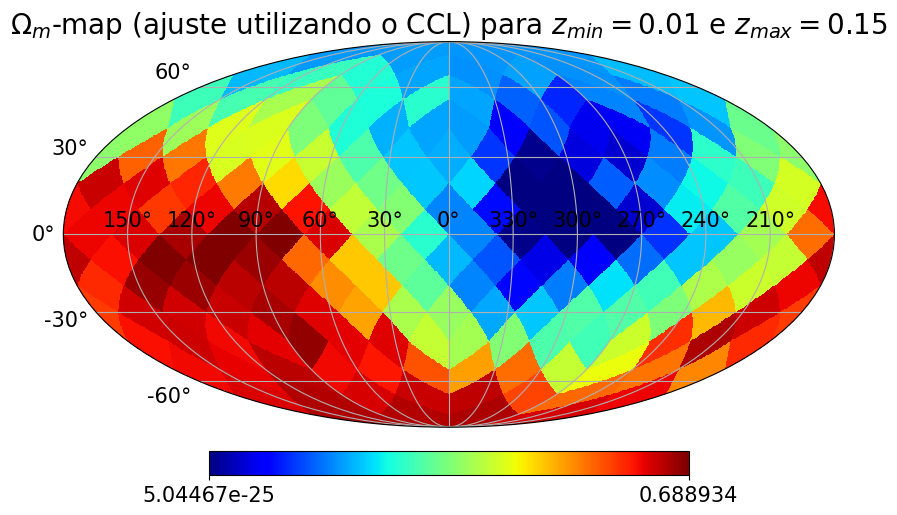

In [38]:
projview(Om_map1,
coord=["G"],
norm="hist",
cmap='jet',
title="$\Omega_m$-map (ajuste utilizando a integral) para $z_{min}=0.01$ e $z_{max}=0.15$",
graticule=True,
graticule_labels=True,
longitude_grid_spacing=30,
projection_type="mollweide",
fontsize=fontsize)
plt.savefig('/home/sofia/Documentos/Pantheon/Atividade 4/Om_map_int_1.png', dpi=600, bbox_inches='tight')

projview(Om_map_c1,
coord=["G"],
norm="hist",
cmap='jet',
title="$\Omega_m$-map (ajuste utilizando o CCL) para $z_{min}=0.01$ e $z_{max}=0.15$",
graticule=True,
graticule_labels=True,
longitude_grid_spacing=30,
projection_type="mollweide",
fontsize=fontsize)
plt.savefig('/home/sofia/Documentos/Pantheon/Atividade 4/Om_map_ccl_1.png', dpi=600, bbox_inches='tight')

plt.show()

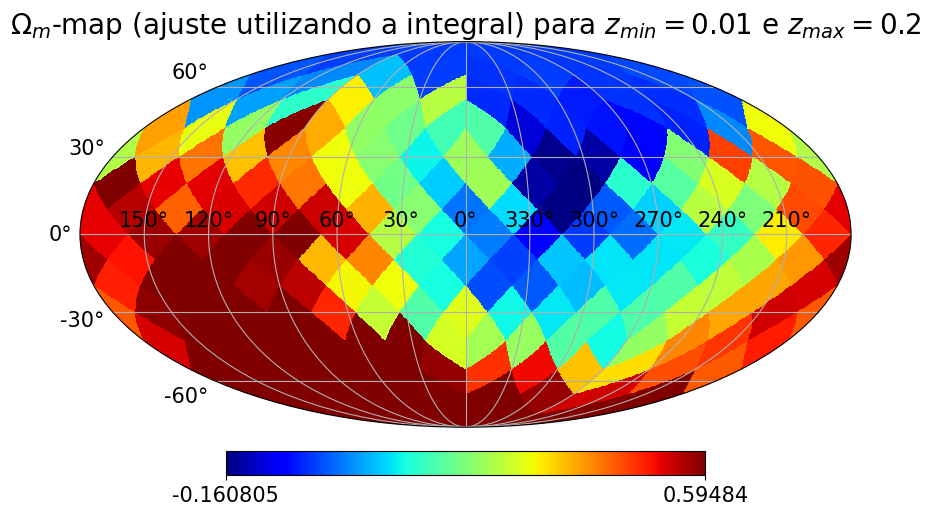

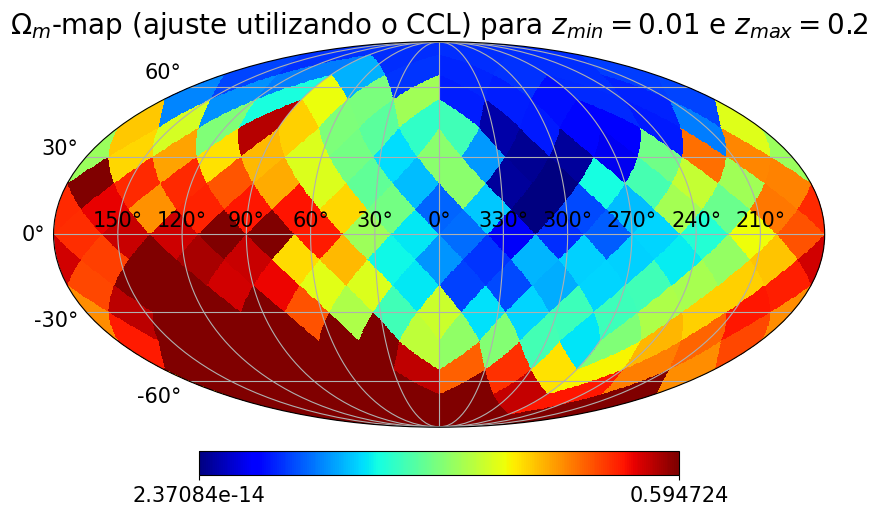

In [39]:
projview(Om_map2,
coord=["G"],
norm="hist",
cmap='jet',
title="$\Omega_m$-map (ajuste utilizando a integral) para $z_{min}=0.01$ e $z_{max}=0.2$",
graticule=True,
graticule_labels=True,
longitude_grid_spacing=30,
projection_type="mollweide",
fontsize=fontsize)
plt.savefig('/home/sofia/Documentos/Pantheon/Atividade 4/Om_map_int_2.png', dpi=600, bbox_inches='tight')

projview(Om_map_c2,
coord=["G"],
norm="hist",
cmap='jet',
title="$\Omega_m$-map (ajuste utilizando o CCL) para $z_{min}=0.01$ e $z_{max}=0.2$",
graticule=True,
graticule_labels=True,
longitude_grid_spacing=30,
projection_type="mollweide",
fontsize=fontsize)
plt.savefig('/home/sofia/Documentos/Pantheon/Atividade 4/Om_map_ccl_2.png', dpi=600, bbox_inches='tight')

plt.show()

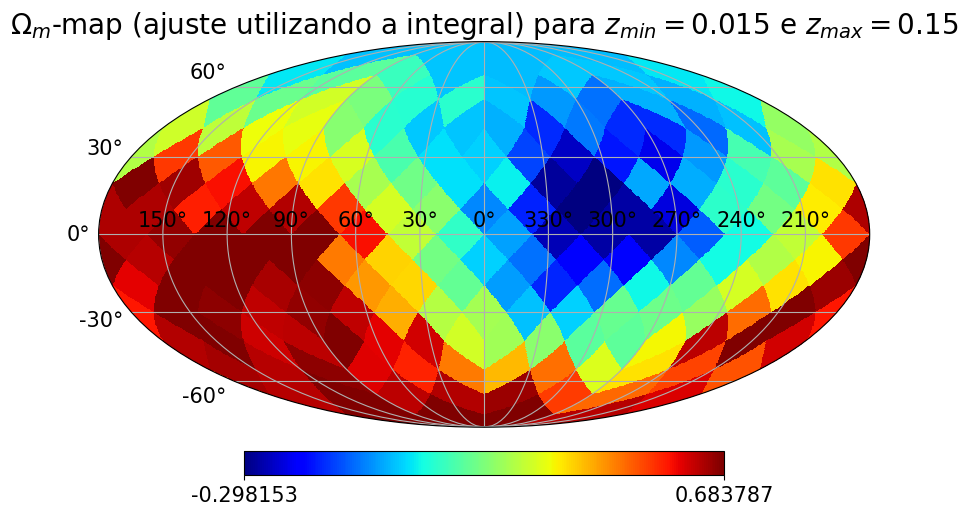

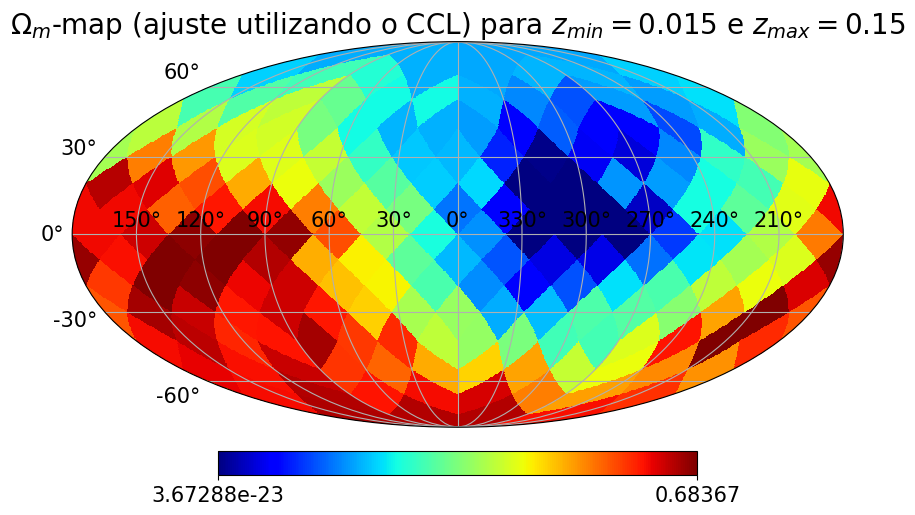

In [40]:
projview(Om_map3,
coord=["G"],
norm="hist",
cmap='jet',
title="$\Omega_m$-map (ajuste utilizando a integral) para $z_{min}=0.015$ e $z_{max}=0.15$",
graticule=True,
graticule_labels=True,
longitude_grid_spacing=30,
projection_type="mollweide",
fontsize=fontsize)
plt.savefig('/home/sofia/Documentos/Pantheon/Atividade 4/Om_map_int_3.png', dpi=600, bbox_inches='tight')

projview(Om_map_c3,
coord=["G"],
norm="hist",
cmap='jet',
title="$\Omega_m$-map (ajuste utilizando o CCL) para $z_{min}=0.015$ e $z_{max}=0.15$",
graticule=True,
graticule_labels=True,
longitude_grid_spacing=30,
projection_type="mollweide",
fontsize=fontsize)
plt.savefig('/home/sofia/Documentos/Pantheon/Atividade 4/Om_map_ccl_3.png', dpi=600, bbox_inches='tight')

plt.show()

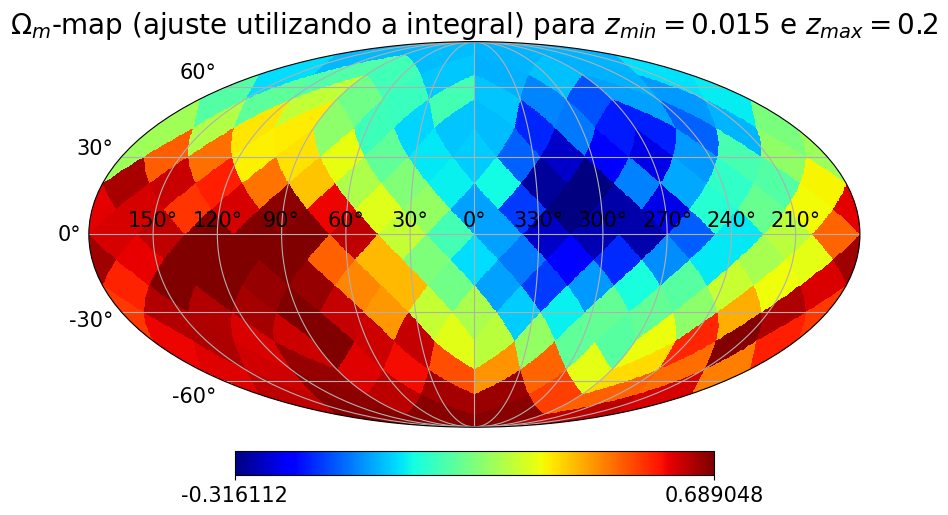

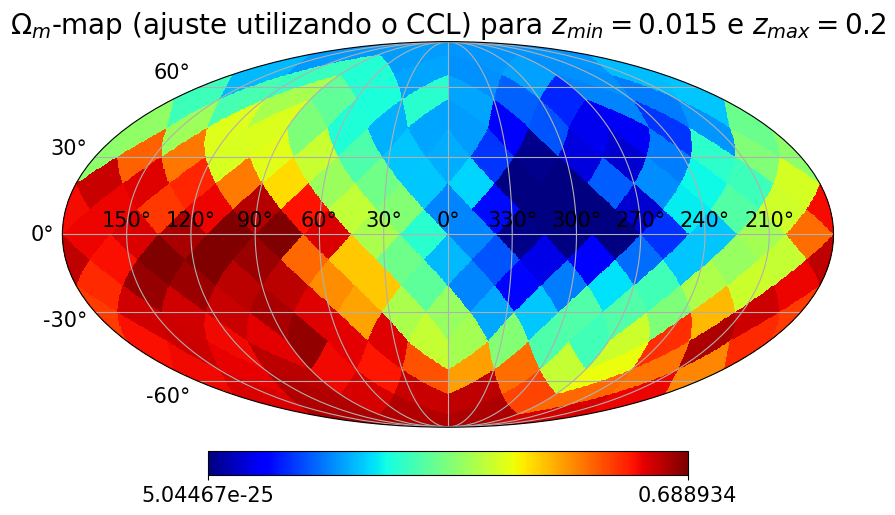

In [41]:
projview(Om_map4,
coord=["G"],
norm="hist",
cmap='jet',
title="$\Omega_m$-map (ajuste utilizando a integral) para $z_{min}=0.015$ e $z_{max}=0.2$",
graticule=True,
graticule_labels=True,
longitude_grid_spacing=30,
projection_type="mollweide",
fontsize=fontsize)
plt.savefig('/home/sofia/Documentos/Pantheon/Atividade 4/Om_map_int_4.png', dpi=600, bbox_inches='tight')

projview(Om_map_c4,
coord=["G"],
norm="hist",
cmap='jet',
title="$\Omega_m$-map (ajuste utilizando o CCL) para $z_{min}=0.015$ e $z_{max}=0.2$",
graticule=True,
graticule_labels=True,
longitude_grid_spacing=30,
projection_type="mollweide",
fontsize=fontsize)
plt.savefig('/home/sofia/Documentos/Pantheon/Atividade 4/Om_map_ccl_4.png', dpi=600, bbox_inches='tight')

plt.show()